In [1]:
#imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

2025-12-27 06:30:35.670909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766817035.955407      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766817036.038856      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766817036.780789      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766817036.780847      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766817036.780850      17 computation_placer.cc:177] computation placer alr

In [2]:
#download dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/chest-xray-pneumonia
['chest_xray']


In [3]:
#inspect folder structure
print(os.listdir(os.path.join(path, 'chest_xray')))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [4]:
#build directory paths
data_dir = os.path.join(path, 'chest_xray', 'chest_xray')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))
print(os.listdir(test_dir))

['val', '.DS_Store', 'test', 'train']
['PNEUMONIA', 'NORMAL', '.DS_Store']
['PNEUMONIA', 'NORMAL', '.DS_Store']
['PNEUMONIA', 'NORMAL', '.DS_Store']


In [5]:
#create dataset from directory(turn image files into batches of tensors + labels)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

#check shapes and label examples
for images, labels in train_ds_raw.take(1):
    print("images shape:", images.shape)   # (32, 224, 224, 3)
    print("labels shape:", labels.shape)   # (32,)
    print("labels example:", labels[:10].numpy())

print('class names:', train_ds_raw.class_names)
print('class names:', val_ds_raw.class_names)
print('class names:', test_ds_raw.class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


2025-12-27 06:31:08.750948: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 624 files belonging to 2 classes.
images shape: (32, 224, 224, 3)
labels shape: (32,)
labels example: [1 1 1 1 0 1 0 1 1 1]
class names: ['NORMAL', 'PNEUMONIA']
class names: ['NORMAL', 'PNEUMONIA']
class names: ['NORMAL', 'PNEUMONIA']


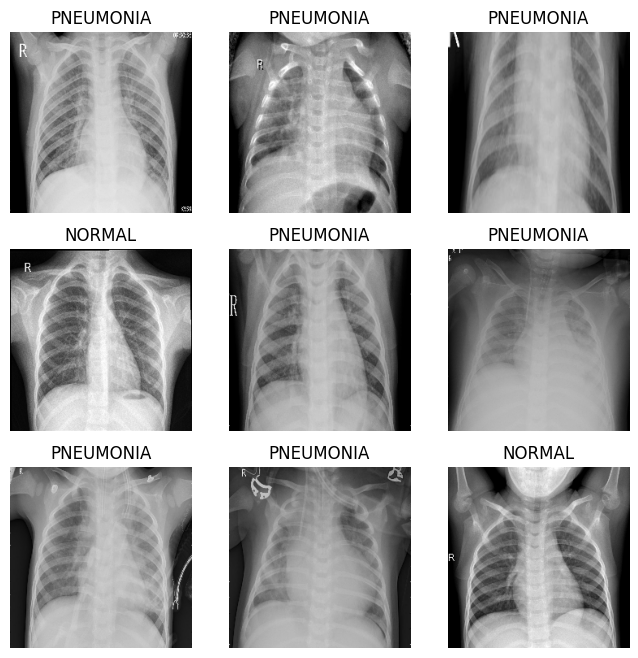

In [6]:
#visual check
for images, labels in train_ds_raw.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label = labels[i].numpy()
        plt.title(train_ds_raw.class_names[label])
        plt.axis('off')

In [7]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

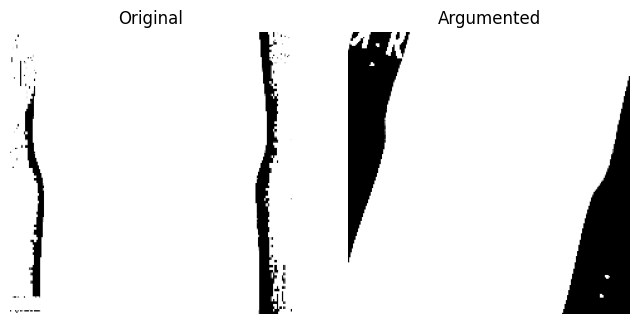

In [8]:
#preview augmentation on a single image(before model training)
for images, labels in train_ds_raw.take(1):
    sample_image = images[0]

augmented_image = data_augmentation(
    tf.expand_dims(sample_image, 0), training=True
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(augmented_image[0])
plt.title('Argumented')
plt.axis('off')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

#normalize to [0,1]
def normalize(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds = train_ds_raw.map(normalize, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_raw.map(normalize, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_raw.map(normalize, num_parallel_calls=AUTOTUNE)

#cache + prefetch
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

for images, labels in train_ds.take(1):
    print(images.dtype, images.numpy().min(), images.numpy().max(), images.shape)

<dtype: 'float32'> 0.0 1.0 (32, 224, 224, 3)


In [10]:
CLASS_NAMES = train_ds_raw.class_names
print("class_names:", CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)

class_names: ['NORMAL', 'PNEUMONIA']


In [11]:
#baseline CNN
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,561,633 (21.22 MB)

 Trainable params: 5,561,633 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=2
)

Epoch 1/3
163/163 - 176s - 1s/step - accuracy: 0.8363 - auc: 0.8714 - loss: 0.3785 - precision: 0.8555 - recall: 0.9381 - val_accuracy: 0.9375 - val_auc: 0.9375 - val_loss: 0.4109 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 2/3
163/163 - 150s - 921ms/step - accuracy: 0.9195 - auc: 0.9626 - loss: 0.2119 - precision: 0.9406 - recall: 0.9517 - val_accuracy: 0.8125 - val_auc: 0.9219 - val_loss: 0.3618 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/3
163/163 - 151s - 926ms/step - accuracy: 0.9331 - auc: 0.9762 - loss: 0.1722 - precision: 0.9518 - recall: 0.9585 - val_accuracy: 0.8750 - val_auc: 0.9609 - val_loss: 0.3917 - val_precision: 0.8000 - val_recall: 1.0000


In [13]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[6 2]
 [0 8]]


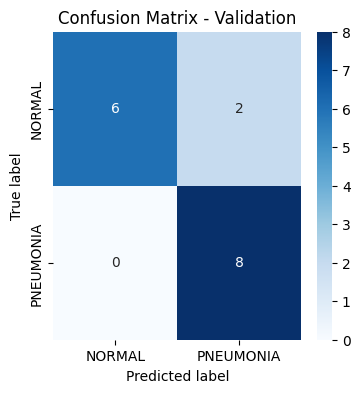

In [15]:
import seaborn as sns

plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Validation')
plt.show()

In [16]:
for images, labels in val_ds.take(1):
    val_images = images
    val_labels = labels

In [17]:
pred_probs = model.predict(val_images)
print(pred_probs.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
(16, 1)


/tmp/ipykernel_17/428186526.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(pred_probs[i])


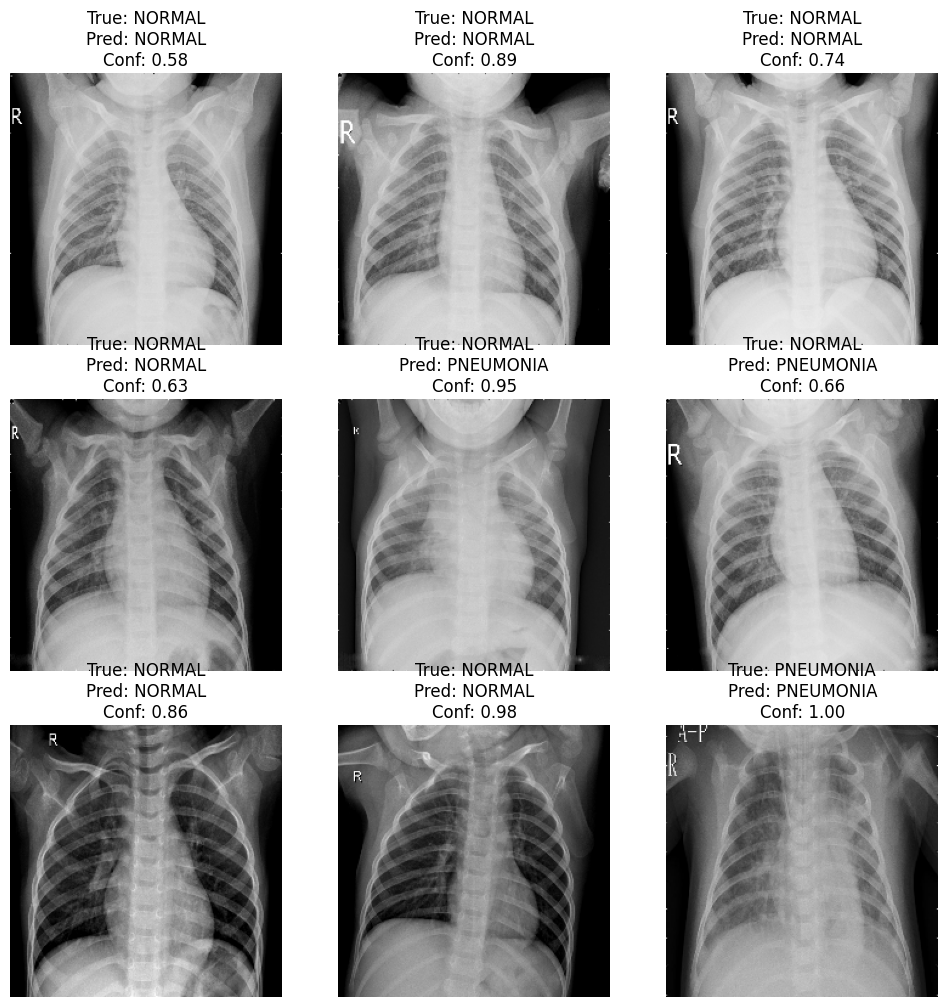

In [18]:
plt.figure(figsize=(12,12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = val_images[i].numpy()
    true_label = val_labels[i].numpy()
    prob = float(pred_probs[i])

    pred_label = 1 if prob > 0.5 else 0
    confidence = prob if pred_label == 1 else (1 - prob)

    plt.imshow(img)
    plt.axis('off')

    title = (
        f"True: {CLASS_NAMES[true_label]}\n"
        f"Pred: {CLASS_NAMES[pred_label]}\n"
        f"Conf: {confidence:.2f}"
    )
    plt.title(title)

plt.show()

In [19]:
test_metrics = model.evaluate(test_ds, verbose=0)
print(dict(zip(model.metrics_names, test_metrics)))

{'loss': 0.4690319001674652, 'compile_metrics': 0.8189102411270142}


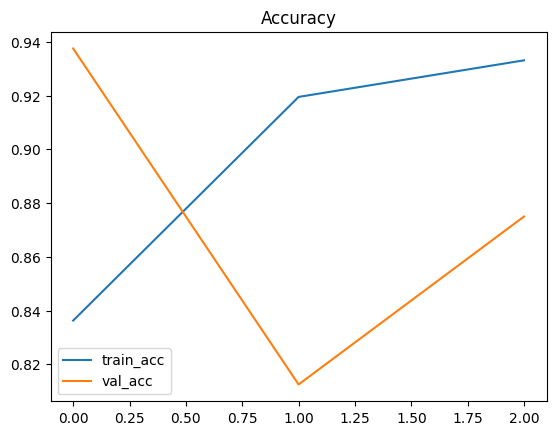

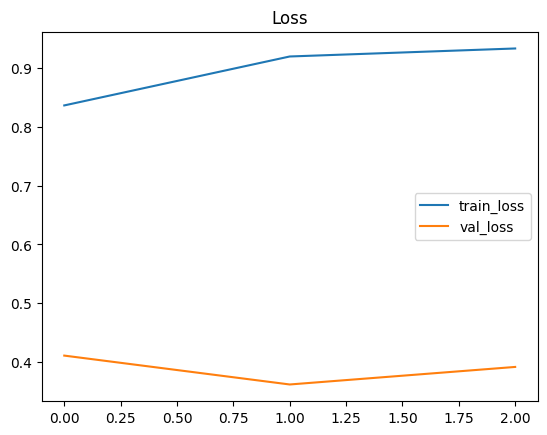

In [20]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['accuracy'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()